In [1]:
# @title
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import wordcloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path = "/content/drive/MyDrive/Data_Science /Data_set/TruthSeeker2023/TSMD_With_TimeStamps 1.csv"

In [3]:
df = pd.read_csv(path)

<ipython-input-3-7b06c29b8c94>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [4]:
print(df.head())

  Unnamed: 0      author                                          statement  \
0          0  D.L. Davis  End of eviction moratorium means millions of A...   
1          1  D.L. Davis  End of eviction moratorium means millions of A...   
2          2  D.L. Davis  End of eviction moratorium means millions of A...   
3          3  D.L. Davis  End of eviction moratorium means millions of A...   
4          4  D.L. Davis  End of eviction moratorium means millions of A...   

   target  BinaryNumTarget                 manual_keywords  \
0     1.0              1.0  Americans, eviction moratorium   
1     1.0              1.0  Americans, eviction moratorium   
2     1.0              1.0  Americans, eviction moratorium   
3     1.0              1.0  Americans, eviction moratorium   
4     1.0              1.0  Americans, eviction moratorium   

                                               tweet 5_label_majority_answer  \
0  @POTUS Biden Blunders - 6 Month Update\n\nInfl...            Mostly A

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134203 entries, 0 to 134202
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               134203 non-null  object 
 1   author                   134202 non-null  object 
 2   statement                134202 non-null  object 
 3   target                   134198 non-null  float64
 4   BinaryNumTarget          134198 non-null  float64
 5   manual_keywords          134198 non-null  object 
 6   tweet                    134197 non-null  object 
 7   5_label_majority_answer  134194 non-null  object 
 8   3_label_majority_answer  134194 non-null  object 
 9   timestamp                134194 non-null  object 
dtypes: float64(2), object(8)
memory usage: 10.2+ MB


In [6]:
print(df.shape)

(134203, 10)


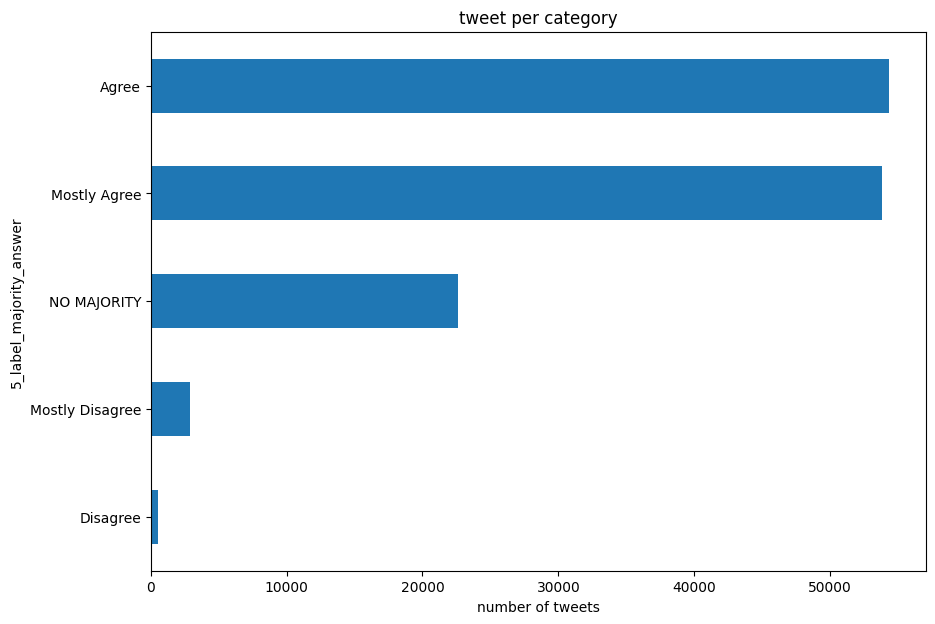

In [7]:
fig = plt.figure(figsize = (10, 7))
df.groupby('5_label_majority_answer')['tweet'].count().sort_values().plot.barh(ylim = 0, title = 'tweet per category')
plt.xlabel('number of tweets')
plt.show()

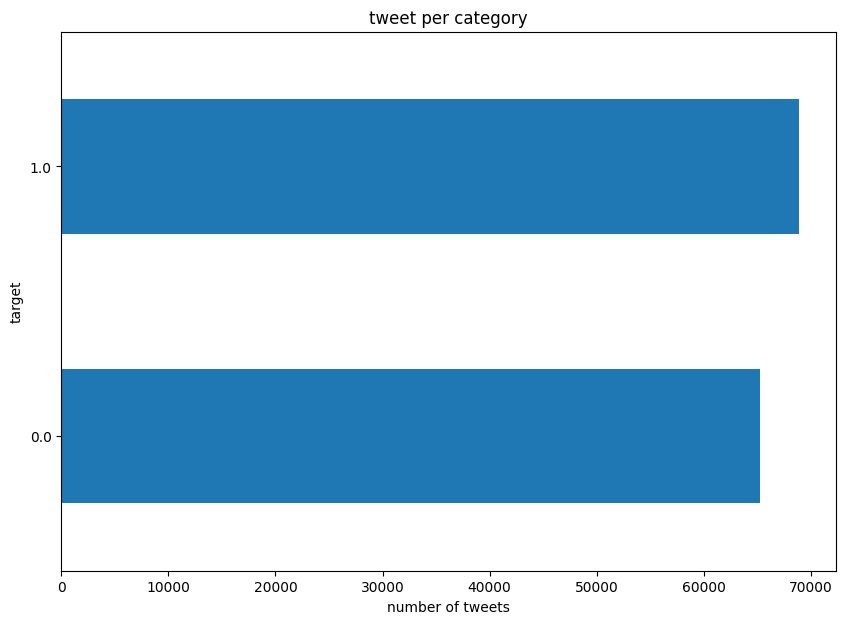

In [8]:
fig = plt.figure(figsize = (10, 7))
# Use parentheses () instead of square brackets [] with groupby
df.groupby('target')['tweet'].count().sort_values().plot.barh(ylim = 0, title = 'tweet per category')
plt.xlabel('number of tweets')
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134203 entries, 0 to 134202
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Unnamed: 0               134203 non-null  object 
 1   author                   134202 non-null  object 
 2   statement                134202 non-null  object 
 3   target                   134198 non-null  float64
 4   BinaryNumTarget          134198 non-null  float64
 5   manual_keywords          134198 non-null  object 
 6   tweet                    134197 non-null  object 
 7   5_label_majority_answer  134194 non-null  object 
 8   3_label_majority_answer  134194 non-null  object 
 9   timestamp                134194 non-null  object 
dtypes: float64(2), object(8)
memory usage: 10.2+ MB


In [10]:
df['manual_keywords'].head()

,manual_keywords
0,"Americans, eviction moratorium"
1,"Americans, eviction moratorium"
2,"Americans, eviction moratorium"
3,"Americans, eviction moratorium"
4,"Americans, eviction moratorium"


In [11]:
df = df.drop(['Unnamed: 0','author','statement','BinaryNumTarget','manual_keywords','5_label_majority_answer','3_label_majority_answer','timestamp'],axis = 1)

In [12]:
df['tweet'] = df['tweet'].astype(str)

In [13]:
def remove_mentions(tweet):
  tweet = re.sub(r'@\w+', '', tweet)
  return tweet
df['tweet'] = df['tweet'].apply(remove_mentions)

In [14]:
def remove_punctuation(text):
  if isinstance(text, str):
      regular_punct = list(string.punctuation)
      for punc in regular_punct:
          if punc in text:
              text = text.replace(punc, ' ')
      return text.strip().lower()
  else:
      return text
df['tweet'] = df['tweet'].apply(remove_punctuation)

In [15]:
def remove_stopwords(tweet):
  en_stops = set(stopwords.words('english'))
  tweet = tweet.split()
  tweet = " ".join([word for word in tweet if not word in en_stops])
  return tweet
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [16]:
#df_2['tweet'] = df_2['tweet'].apply(word_tokenize)

In [17]:
df['text length'] = df['tweet'].apply(len)

In [18]:
df.head()

,target,tweet,text length
0,1.0,biden blunders 6 month update inflation delta ...,226
1,1.0,many people literally starving streets 19th ce...,183
2,1.0,supreme court siding super rich property owner...,155
3,1.0,biden blunders broken campaign promises inflat...,249
4,1.0,agree confluence events right unprecedented af...,176


In [19]:
df.isnull().sum()

,0
target,5
tweet,0
text length,0


In [20]:
df.dropna(inplace=True)

<Figure size 1400x1000 with 0 Axes>

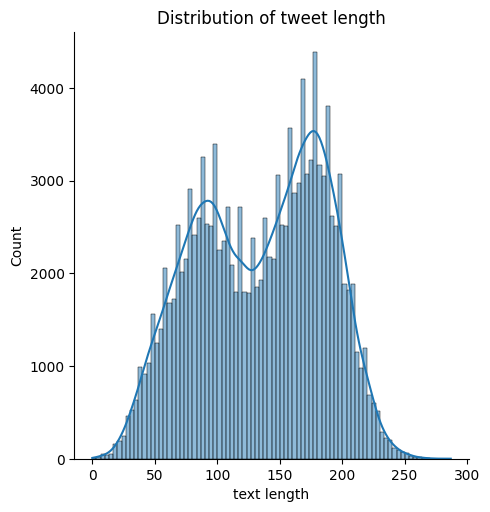

In [21]:
fig = plt.figure(figsize =(14,10))
sns.displot(df['text length'],kde = True)
plt.title('Distribution of tweet length')
plt.show()

In [22]:
text = df[['target','tweet']]

In [23]:
cachedStopWords = stopwords.words("english")

def remove_punc_stopword(text):

  remove_punc = [word for word in text.lower() if word not in string.punctuation]
  remove_punc = ''.join(remove_punc)
  return [word for word in remove_punc.split() if word not in cachedStopWords]

In [24]:
cleaned_text = text.copy()
cleaned_text['tweet'] = cleaned_text['tweet'].apply(remove_punc_stopword)

In [25]:
cleaned_text.head()

,target,tweet
0,1.0,"[biden, blunders, 6, month, update, inflation,..."
1,1.0,"[many, people, literally, starving, streets, 1..."
2,1.0,"[supreme, court, siding, super, rich, property..."
3,1.0,"[biden, blunders, broken, campaign, promises, ..."
4,1.0,"[agree, confluence, events, right, unprecedent..."


In [26]:
def plot_Freq(data):
  fdist = FreqDist(np.concatenate(data.tweet.values))
  fdist.plot(20, cumulative=False)


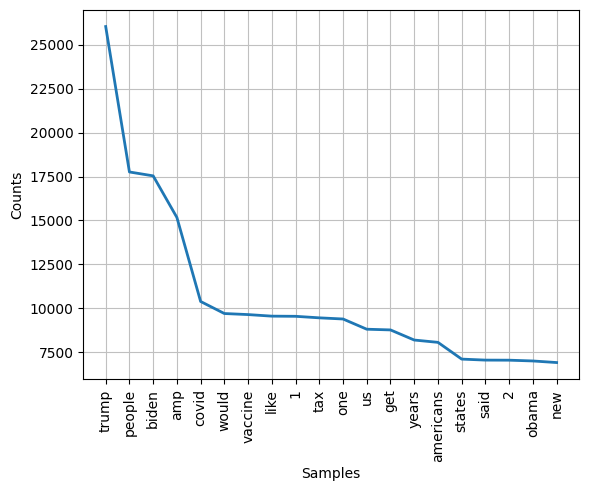

In [27]:
plot_Freq(cleaned_text)

In [28]:
def tweetCloud(target):
    target_text = ' '.join(text[text['target']==target]['tweet'])
    wordcloud_instance = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(target_text))

    wordcloud_image = wordcloud_instance.to_array()
    fig = plt.figure(
      figsize = (10,7),
      facecolor = 'k',
      edgecolor = 'k')
    plt.imshow(wordcloud_image, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

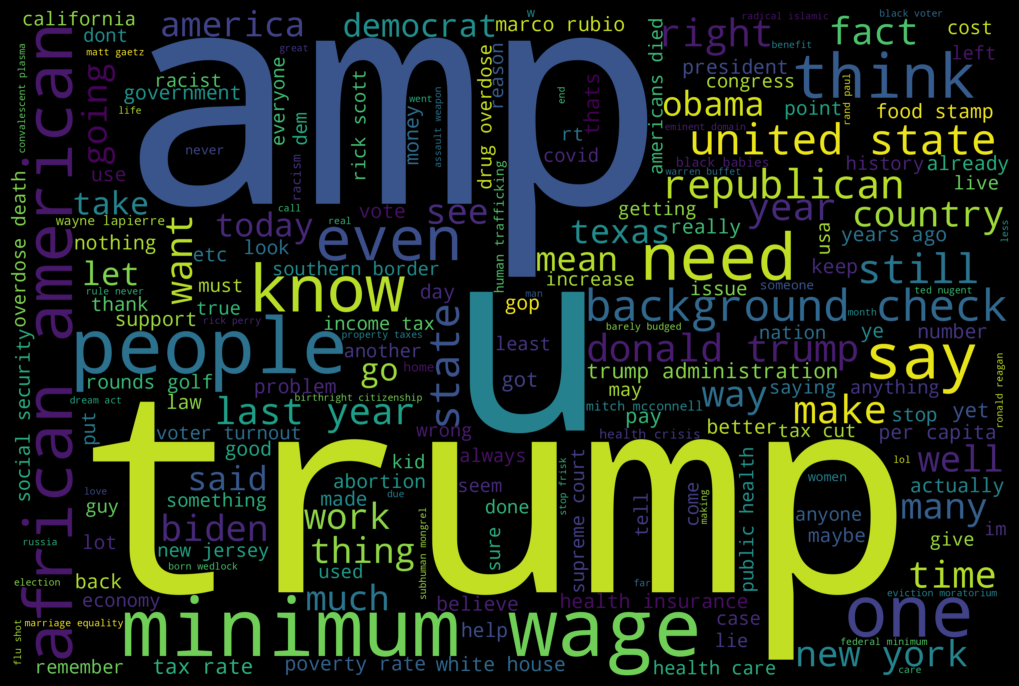

In [29]:
tweetCloud(1)

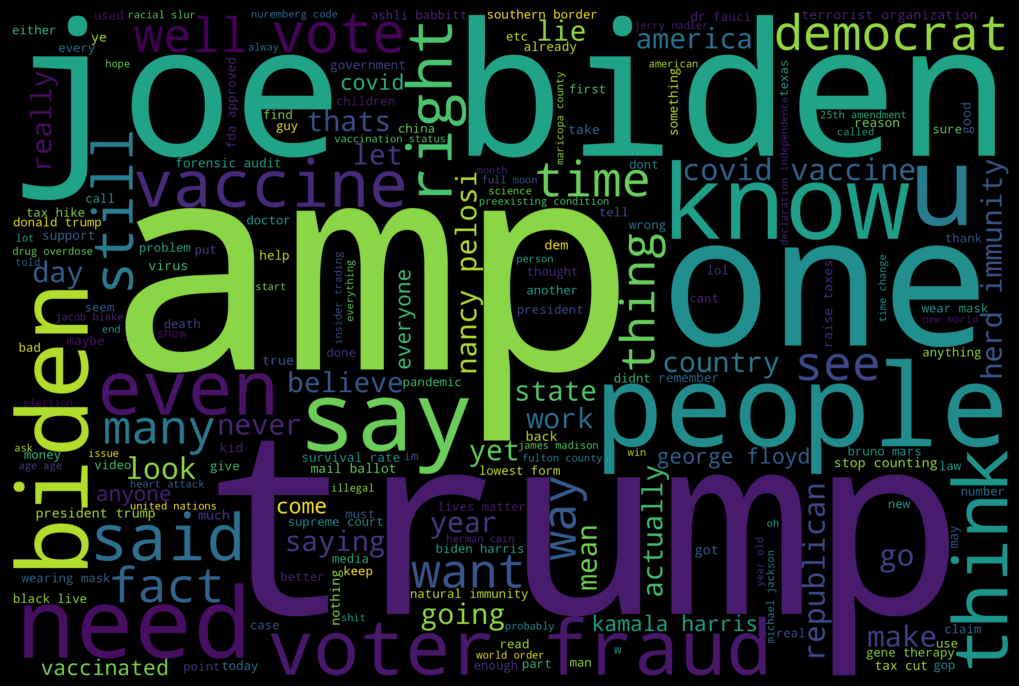

In [30]:
tweetCloud(0)

In [31]:
vectorizer = TfidfVectorizer(max_features=8000)
cleaned_text['tweet'] = cleaned_text['tweet'].apply(lambda x: ' '.join(x))
X = vectorizer.fit_transform(cleaned_text['tweet'])
y= cleaned_text['target']
print(X.shape)
print(y.shape)

(134198, 8000)
(134198,)


In [32]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:

inputs = Input(shape=(x_train.shape[1],))
x = Dense(128, activation='relu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation= 'sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])


In [34]:
'''
inputs = Input(shape=(x_train.shape[1],))
x = Embedding(input_dim=10000, output_dim=128)(inputs)
x = LSTM(128,return_sequences=False)(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation= 'sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])
'''

"\ninputs = Input(shape=(x_train.shape[1],))\nx = Embedding(input_dim=10000, output_dim=128)(inputs)\nx = LSTM(128,return_sequences=False)(x)\nx = Dropout(0.3)(x)\noutputs = Dense(1, activation= 'sigmoid')(x)\n\nmodel = Model(inputs, outputs)\nmodel.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])\n"

In [35]:
Early_stop = EarlyStopping(monitor= 'val_loss',patience=2, restore_best_weights=True)

history = model.fit(x_train,y_train,
                    batch_size = 512,
                    epochs = 10,
                    validation_split=0.1,
                    callbacks=[Early_stop],
                    verbose = 1
                    )


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.8958 - loss: 0.2348 - val_accuracy: 0.9577 - val_loss: 0.3762
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - accuracy: 0.9905 - loss: 0.0296 - val_accuracy: 0.9753 - val_loss: 0.1318
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9965 - loss: 0.0109 - val_accuracy: 0.9827 - val_loss: 0.0463
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9986 - loss: 0.0049 - val_accuracy: 0.9844 - val_loss: 0.0533
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9851 - val_loss: 0.0585


In [36]:
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

839/839 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9862 - loss: 0.0416
Test Loss: 0.043536409735679626
Test Accuracy: 0.985543966293335


In [37]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred))

839/839 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     13076
         1.0       0.99      0.98      0.99     13764

    accuracy                           0.99     26840
   macro avg       0.99      0.99      0.99     26840
weighted avg       0.99      0.99      0.99     26840



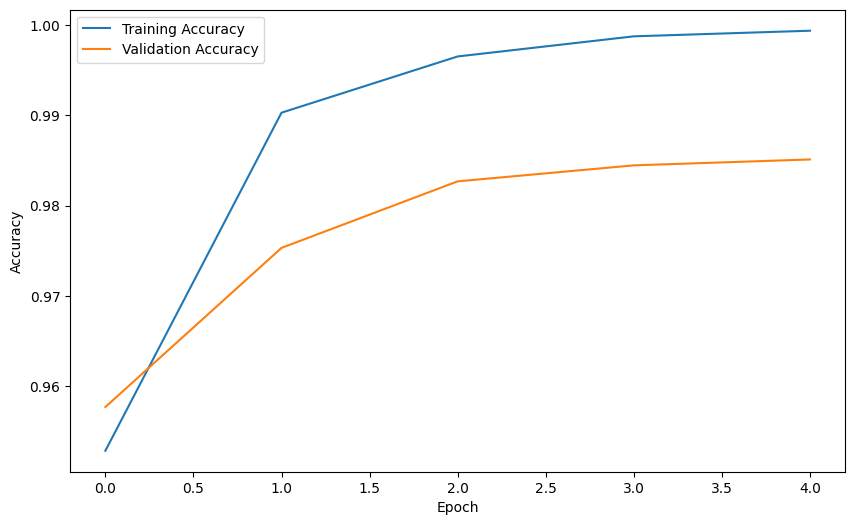

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

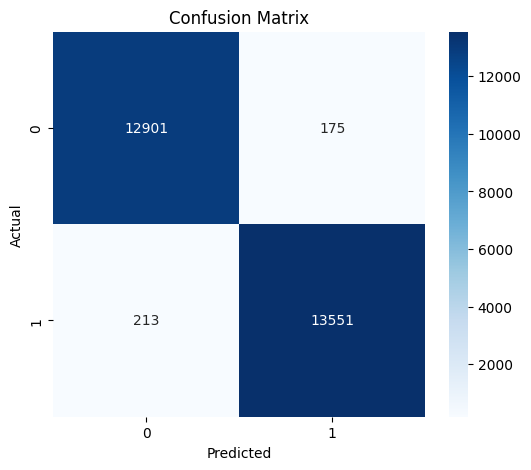

In [39]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [40]:
models_ml = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Linear SVM": LinearSVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')}
accuracies_ml = {}


===== Model: Logistic Regression =====
Accuracy: 0.9777
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     13076
         1.0       0.98      0.98      0.98     13764

    accuracy                           0.98     26840
   macro avg       0.98      0.98      0.98     26840
weighted avg       0.98      0.98      0.98     26840



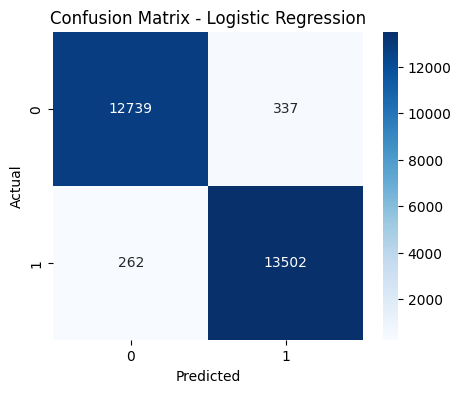


===== Model: Random Forest =====
Accuracy: 0.9849
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     13076
         1.0       0.99      0.98      0.99     13764

    accuracy                           0.98     26840
   macro avg       0.98      0.99      0.98     26840
weighted avg       0.98      0.98      0.98     26840



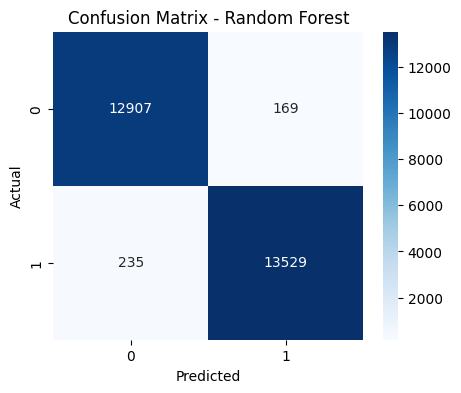


===== Model: Linear SVM =====
Accuracy: 0.9828
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     13076
         1.0       0.98      0.98      0.98     13764

    accuracy                           0.98     26840
   macro avg       0.98      0.98      0.98     26840
weighted avg       0.98      0.98      0.98     26840



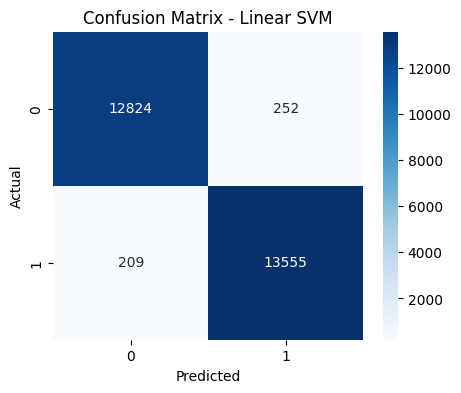


===== Model: XGBoost =====


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:13:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9696
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     13076
         1.0       0.96      0.98      0.97     13764

    accuracy                           0.97     26840
   macro avg       0.97      0.97      0.97     26840
weighted avg       0.97      0.97      0.97     26840



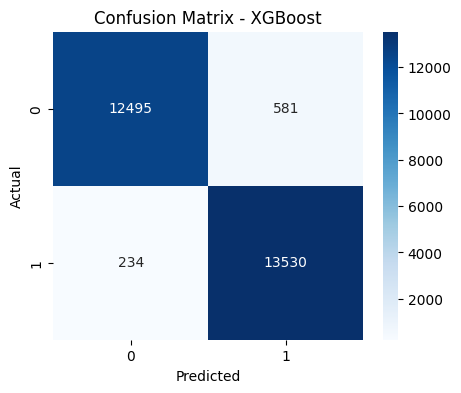

In [41]:
for name, model in models_ml.items():
    print(f"\n===== Model: {name} =====")
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    acc = accuracy_score(y_test, y_pred)
    accuracies_ml[name] = acc
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

<ipython-input-42-384c3a25ce4b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(accuracies_ml.keys()) + ['Deep Learning'], y=list(accuracies_ml.values()) + [accuracy], palette="viridis")


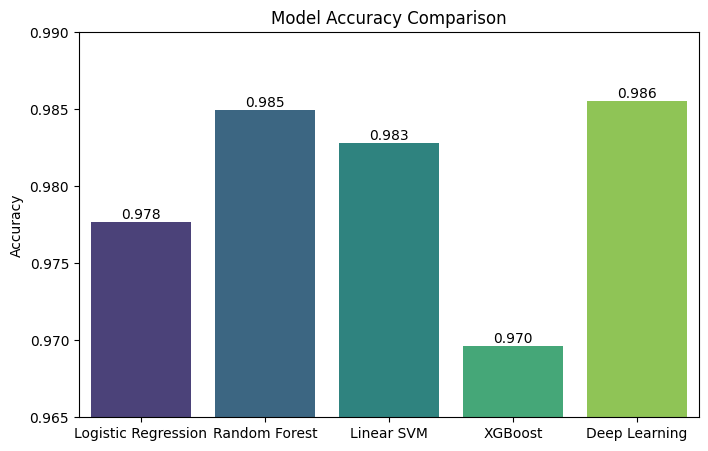

In [42]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=list(accuracies_ml.keys()) + ['Deep Learning'], y=list(accuracies_ml.values()) + [accuracy], palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.965, .99)
#plt.grid(axis= 'y', linestyle = '--')
plt.xticks(rotation=0)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.005))
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0,5),textcoords='offset points')
plt.show()